In [1]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
import os

Using TensorFlow backend.


In [0]:
intermediate_dim = 512
batch_size = 128
latent_dim = 4
epochs = 100

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

input_shape = (original_dim, )

11493376/11490434 [==============================] - 2s 0us/step


In [0]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1] # Returns the shape of tensor or variable as a tuple of int or None entries.
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [0]:
# VAE model = encoder + decoder
# build encoder model
def encoder_model(inputs):
    x = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder, z_mean, z_log_var

In [6]:
inputs = Input(shape=input_shape, name='encoder_input')
encoder, z_mean, z_log_var = encoder_model(inputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 4)            2052        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 4)            2052        dense_1[0][0]                    
____________________________________________________________________________________________

In [0]:
# build decoder model
def decoder_model():
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(original_dim, activation='sigmoid')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder

In [8]:
decoder = decoder_model()
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2560      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               402192    
Total params: 404,752
Trainable params: 404,752
Non-trainable params: 0
_________________________________________________________________


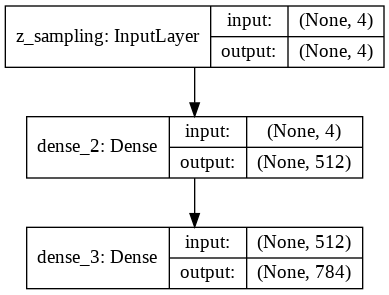

In [9]:
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

In [0]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [11]:
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 4), (None, 4), (N 406024    
_________________________________________________________________
decoder (Model)              (None, 784)               404752    
Total params: 810,776
Trainable params: 810,776
Non-trainable params: 0
_________________________________________________________________


In [12]:
reconstruction_loss = mse(inputs, outputs)
# reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = (1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [13]:
 vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
# vae.save_weights('vae_mlp_mnist_latent_dim_%s.h5' %latent_dim)
#vae.load_weights('vae_mlp_mnist_latent_dim_2.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 60us/step - loss: 48.5931 - val_loss: 39.7176
Epoch 2/100
60000/60000 [==============================] - 2s 32us/step - loss: 38.5444 - val_loss: 37.4086
Epoch 3/100
60000/60000 [==============================] - 2s 31us/step - loss: 37.0728 - val_loss: 36.4443
Epoch 4/100
60000/60000 [==============================] - 2s 31us/step - loss: 36.2977 - val_loss: 35.7963
Epoch 5/100
60000/60000 [==============================] - 2s 34us/step - loss: 35.7209 - val_loss: 35.3138
Epoch 6/100
60000/60000 [==============================] - 2s 31us/step - loss: 35.2789 - val_loss: 34.9510
Epoch 7/100
60000/60000 [==============================] - 2s 34us/step - loss: 34.9042 - val_loss: 34.6324
Epoch 8/100
60000/60000 [==============================] - 2s 31us/step - loss: 34.5887 - val_loss: 34.3414
Epoch 9/100
60000/60000 [==============================] - 2s 31us/step - loss: 34.278

FileNotFoundError: ignored

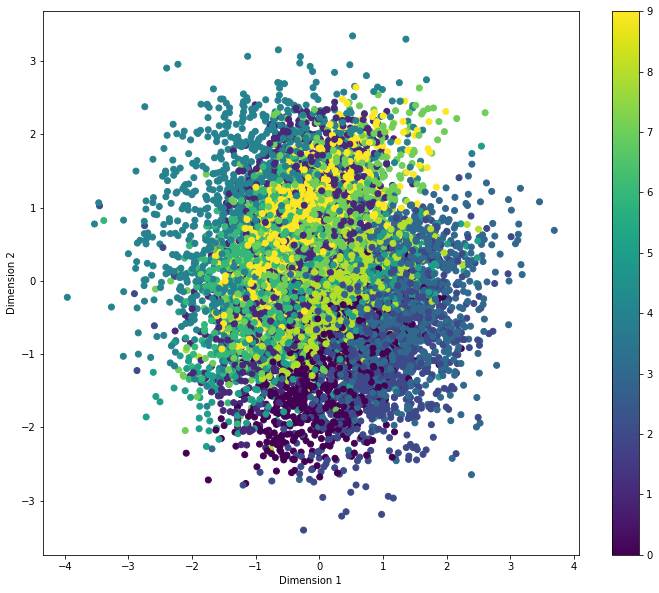

In [14]:
model_name = 'vae_mnist'
filename = os.path.join(model_name, "vae_mean.png")
# display a 2D plot of the digit classes in the latent space
z_mean, _, _ = encoder.predict(x_test,
                               batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.savefig(filename)


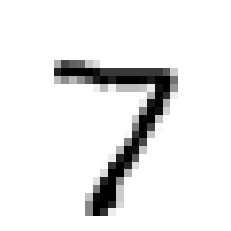

In [15]:
plt.ioff()
img = np.reshape(x_test[0], (image_size, image_size))
plt.axis('off')
plt.imshow(img, cmap = 'gray_r')
plt.savefig('seven_original.png')

In [0]:
encoder_input = np.expand_dims(x_test[0], axis = 0)

In [17]:
encoder_input.shape, encoder.input_shape

((1, 784), (None, 784))

In [0]:
mean, var, z = encoder.predict(encoder_input)

In [0]:
decoded_output = decoder.predict(mean)

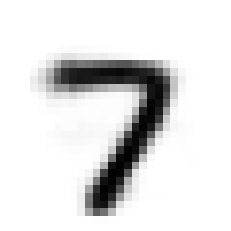

In [20]:
plt.ioff()
img = np.reshape(x_test[0], (image_size, image_size))
plt.axis('off')
plt.imshow(np.reshape(decoded_output, (image_size, image_size)), cmap = 'gray_r')
plt.savefig('seven_reproduced.png')

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
save_path = "/content/drive/My Drive/"

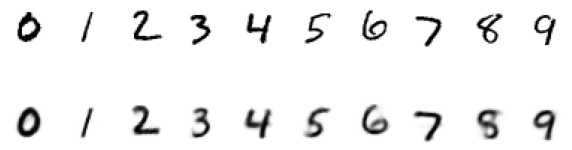

In [26]:
n_to_show = 10
fig = plt.figure(figsize=(10, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

img = np.reshape(x_test[3], (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 0+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')

img = np.reshape(x_test[2], (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 1+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')

img = np.reshape(x_test[1], (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 2+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')

img = np.reshape(x_test[30], (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 3+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')

img = np.reshape(x_test[56], (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 4+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')

img = np.reshape(x_test[23], (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 5+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')
img = np.reshape(x_test[11], (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 6+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')

img = np.reshape(x_test[17], (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 7+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')

img = np.reshape(x_test[84], (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 8+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')

img = np.reshape(x_test[16], (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 9+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')



encoder_input = np.expand_dims(x_test[3], axis = 0)
mean, var, z = encoder.predict(encoder_input)
decoded_output = decoder.predict(mean)
img = np.reshape(decoded_output, (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 0+n_to_show+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')

encoder_input = np.expand_dims(x_test[2], axis = 0)
mean, var, z = encoder.predict(encoder_input)
decoded_output = decoder.predict(mean)
img = np.reshape(decoded_output, (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 1+n_to_show+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')
encoder_input = np.expand_dims(x_test[1], axis = 0)
mean, var, z = encoder.predict(encoder_input)
decoded_output = decoder.predict(mean)
img = np.reshape(decoded_output, (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 2+n_to_show+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')
encoder_input = np.expand_dims(x_test[30], axis = 0)
mean, var, z = encoder.predict(encoder_input)
decoded_output = decoder.predict(mean)
img = np.reshape(decoded_output, (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 3+n_to_show+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')
encoder_input = np.expand_dims(x_test[56], axis = 0)
mean, var, z = encoder.predict(encoder_input)
decoded_output = decoder.predict(mean)
img = np.reshape(decoded_output, (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 4+n_to_show+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')
encoder_input = np.expand_dims(x_test[23], axis = 0)
mean, var, z = encoder.predict(encoder_input)
decoded_output = decoder.predict(mean)
img = np.reshape(decoded_output, (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 5+n_to_show+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')
encoder_input = np.expand_dims(x_test[11], axis = 0)
mean, var, z = encoder.predict(encoder_input)
decoded_output = decoder.predict(mean)
img = np.reshape(decoded_output, (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 6+n_to_show+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')
encoder_input = np.expand_dims(x_test[17], axis = 0)
mean, var, z = encoder.predict(encoder_input)
decoded_output = decoder.predict(mean)
img = np.reshape(decoded_output, (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 7+n_to_show+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')
encoder_input = np.expand_dims(x_test[84], axis = 0)
mean, var, z = encoder.predict(encoder_input)
decoded_output = decoder.predict(mean)
img = np.reshape(decoded_output, (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 8+n_to_show+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')
encoder_input = np.expand_dims(x_test[16], axis = 0)
mean, var, z = encoder.predict(encoder_input)
decoded_output = decoder.predict(mean)
img = np.reshape(decoded_output, (image_size, image_size))
sub = fig.add_subplot(2, n_to_show, 9+n_to_show+1)
sub.axis('off')
sub.imshow(img, cmap='gray_r')



fig.savefig(os.path.join(save_path,"mnist.png"))


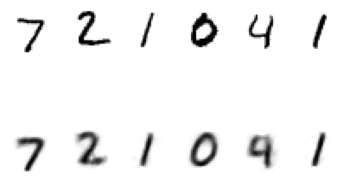

In [0]:

img0 =np.zeros((5,28,28))
img1 =np.zeros((5,28,28))
img =np.zeros((12,28,28))

for i in range(0,6):
  img0[i] = np.reshape(x_test[i], (image_size, image_size))
  encoder_input = np.expand_dims(x_test[i], axis = 0)
  mean, var, z = encoder.predict(encoder_input)
  decoded_output = decoder.predict(mean)
  img1[i] = np.reshape(decoded_output, (image_size, image_size))
  

img = np.concatenate((img0, img1), axis=0)


for i in range(12):
	# define subplot
	plt.subplot(2, 5, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(img[i], cmap='gray_r')
plt.savefig(os.path.join(save_path,"MNIST_compare.png"))
